In [1]:
import ROOT as r
import numpy as np

Welcome to JupyROOT 6.24/06


In [2]:
def MakeWiggle(hist2d_t_e, hist_name, e_start, e_end):
    start_bin = hist2d_t_e.GetYaxis().FindBin(e_start)
    end_bin = hist2d_t_e.GetYaxis().FindBin(e_end)
    wiggle_T = hist2d_t_e.ProjectionX(hist_name, start_bin, end_bin)
    return wiggle_T

def Normalize(hist, start_bin):
    start_time = hist.GetBinCenter(start_bin)
    integral = hist.Integral(start_bin, 4356) * np.exp(start_time/64)
    normalized_lm = hist.Clone('normalized_from_{:.2f}us'.format(start_time))
    normalized_lm.SetTitle('Normalized lost muon from {:.2f}us'.format(start_time))
    normalized_lm.Scale(1/integral)
    return normalized_lm

def Integral(hist, start_bin):
    start_time = hist.GetBinCenter(start_bin)
    integral_lm = hist.Clone('integrate_from_{:.2f}us'.format(start_time))
    integral_lm.Reset()
    integral_lm.SetTitle('Integral lost muon from {:.2f}us'.format(start_time))
    sum_lm = 0
    for i in range(start_bin, hist.GetNbinsX()+1):
        t_prime = hist.GetBinCenter(i)
        sum_lm += hist.GetBinContent(i) * np.exp(t_prime/64.43)
        integral_lm.SetBinContent(i, sum_lm)

    return integral_lm

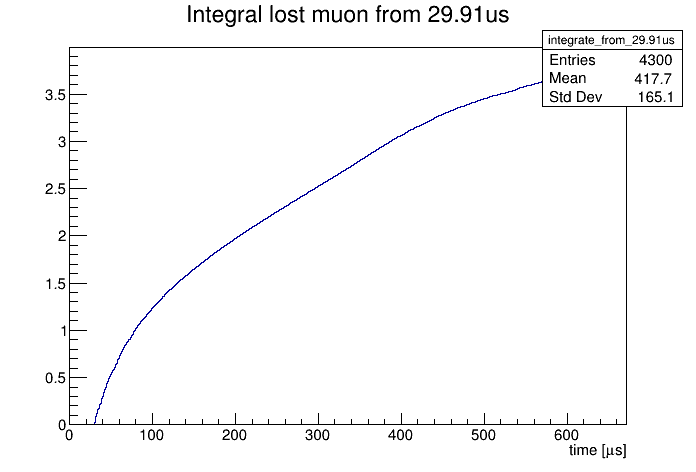

In [4]:
c = r.TCanvas()
f = r.TFile.Open("../run/data/toymc_run100A.root")
hist2d_t_e = f.Get("hist2d_t_e")
hist_lm = f.Get("hist1d_time_lost_")

wiggle_T = MakeWiggle(hist2d_t_e, "wiggle_T", 1700, 3100)

wiggles_energy_bin = []
for energy in range(1000, 3100, 100):
    wiggles_energy_bin.append(MakeWiggle(hist2d_t_e, f"wiggle_e{energy}", energy, energy+100))

normalized_lm = Normalize(hist_lm, start_bin=201)
integral_lm = Integral(normalized_lm, start_bin=201)
integral_lm.Draw()
c.Draw()

out = r.TFile("../run/data/toymc_run100A_ana.root", "recreate")

out.mkdir("lost_muon")
out.cd("lost_muon")
hist_lm.Write("hist_lm")
integral_lm.Write("hist_lm_integral")

out.cd("../")
out.mkdir("wiggle")
out.cd("wiggle")
wiggle_T.Write("wiggle_T")

out.cd("../")
out.mkdir("energy_bin")
out.cd("energy_bin")
for wiggle_energy_bin in wiggles_energy_bin:
    wiggle_energy_bin.Write()

out.Close()